In [1]:
%matplotlib inline
from fastai.basics import *

In [2]:
path = Config().data_path()/'mnist'

In [3]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz.3'),
 PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz.1'),
 PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz'),
 PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz.2')]

In [5]:
with gzip.open(path/"mnist.pkl.gz", 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

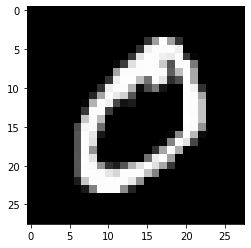

In [8]:
plt.imshow(x_train[1].reshape((28, 28)), cmap='gray')

In [9]:
# Creating torch tensor types
x_train, y_train, x_valid, y_valid = map(torch.tensor, [x_train, y_train, x_valid, y_valid])

In [10]:
n, c = x_train.shape

In [12]:
[x_train.shape, y_train.min(), y_train.max()]

[torch.Size([50000, 784]), tensor(0), tensor(9)]

In [13]:
from torch.utils.data import TensorDataset

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [14]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=bs)

In [15]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [16]:
class MnistLogisticReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    def forward(self, xb):
        return self.lin(xb)

In [37]:
model = MnistLogisticReg().cuda()

In [18]:
model

MnistLogisticReg(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [28]:
for param in model.lin.parameters():
    print(param.size())

torch.Size([10, 784])
torch.Size([10])


In [29]:
model(x).shape

torch.Size([64, 10])

In [30]:
lr = 2e-2

In [31]:
loss_fn = nn.CrossEntropyLoss()

In [39]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_fn(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [40]:
losses = [update(x, y, lr) for x, y in data.train_dl]

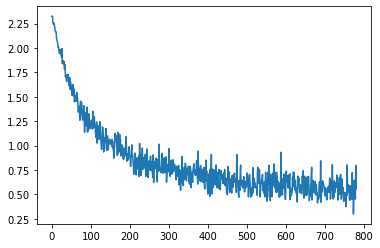

In [41]:
plt.plot(losses)

In [46]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)


In [47]:
model = MnistNN().cuda()

In [49]:
losses = [update(x, y, lr) for x, y in data.train_dl]

In [50]:
model

MnistNN(
  (lin1): Linear(in_features=784, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
)

In [56]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


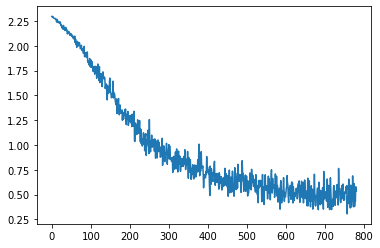

In [57]:
plt.plot(losses)

In [60]:
learn = Learner(data, MnistNN(), loss_func=loss_fn, metrics=accuracy)

In [61]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


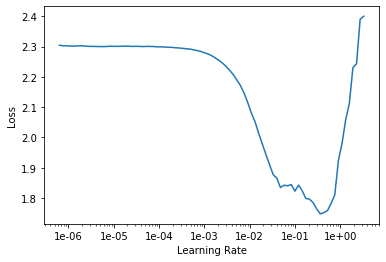

In [62]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.160621,0.131584,0.960800,00:04


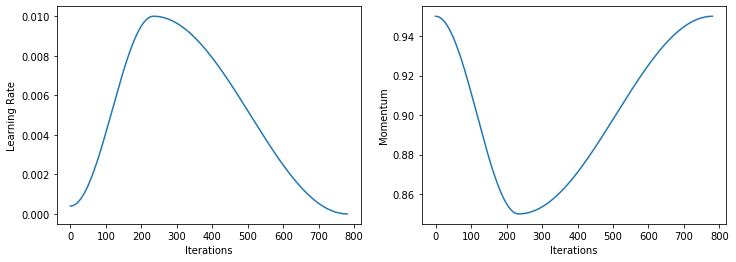

In [64]:
learn.recorder.plot_lr(show_moms=True)

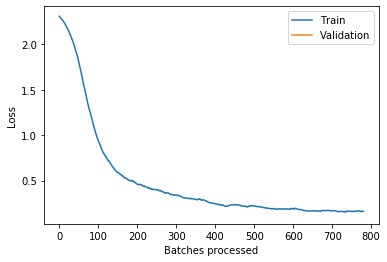

In [65]:
learn.recorder.plot_losses()